## Enhancement of Gravity Data: Calculating Geophysical Attributes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import rioxarray
import xrft
import xarray as xr
import geopandas as gpd
import importlib
from scipy.ndimage import gaussian_filter

In [2]:
import sys
import importlib
sys.path.append('../../modules')
from reading import ascii_xyz
from plotting import raster_plotting
from processing import interpolate

importlib.reload(raster_plotting);

In [3]:
import os
data_dir = os.path.abspath(os.path.join('..', '..', 'data'))
output_dir = os.path.abspath(os.path.join('..', '..', 'output'))

## Data

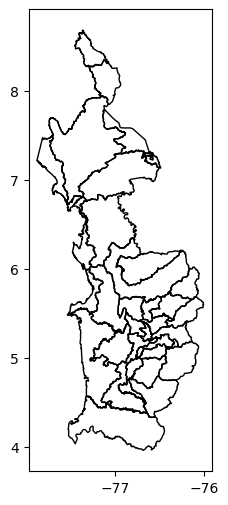

In [32]:
import geopandas as gpd
filename = data_dir + '/vector/colombia/Municipio, Distrito y Area no municipalizada.shp' # Data taken from colombiaenmapas.gov.co
gdf = gpd.read_file(filename)
gdf = gdf.to_crs(epsg=4326)
depto = gdf[gdf['Depto'] == 'Chocó']
depto.plot(figsize=(8,6), edgecolor='black', facecolor='none')
plt.show()

In [33]:
filename = output_dir + r'\raster\atrato_basin\BOU_masked_cg.tif'
data = rioxarray.open_rasterio(filename)
data

<xarray.DataArray (band: 1, y: 11732, x: 6554)> Size: 615MB
[76891528 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 94kB 8.292 8.292 8.292 8.291 ... 5.034 5.034 5.034
  * x            (x) float64 52kB -78.0 -78.0 -78.0 ... -76.18 -76.18 -76.18
    spatial_ref  int64 8B 0
Attributes:
    long_name:      BOU
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

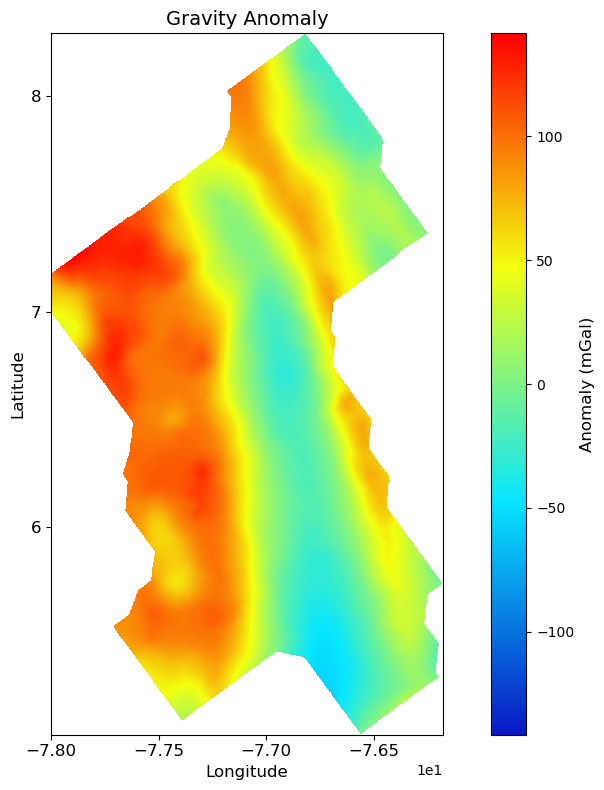

In [34]:
raster_plotting.plot_raster_data(data.x, data.y, data.values[0], data_type='GA', sampling = 10)

In [8]:
raw_bou = data.values[0]
data_grid = vd.make_xarray_grid(
    (data.x.values, data.y.values),
    raw_bou,
    data_names="BOU",
)
data_grid

<xarray.Dataset> Size: 615MB
Dimensions:   (northing: 11732, easting: 6554)
Coordinates:
  * northing  (northing) float64 94kB 8.292 8.292 8.292 ... 5.034 5.034 5.034
  * easting   (easting) float64 52kB -78.0 -78.0 -78.0 ... -76.18 -76.18 -76.18
Data variables:
    BOU       (northing, easting) float64 615MB nan nan nan nan ... nan nan nan

## Residual (Polynomial)

In [9]:
lat, lon = np.meshgrid(data_grid.northing.values, data_grid.easting.values, indexing="ij")
valid_mask = np.isfinite(raw_bou)

coords_valid = (lat[valid_mask], lon[valid_mask])
bou_valid = raw_bou[valid_mask]

trend_model = vd.Trend(degree=3).fit(coords_valid, bou_valid)

trend_full = trend_model.predict((lat.ravel(), lon.ravel())).reshape(raw_bou.shape)

residual = np.full_like(raw_bou, np.nan, dtype=float)
residual[valid_mask] = raw_bou[valid_mask] - trend_full[valid_mask]

regional = np.full_like(raw_bou, np.nan, dtype=float)
regional[valid_mask] = trend_full[valid_mask]

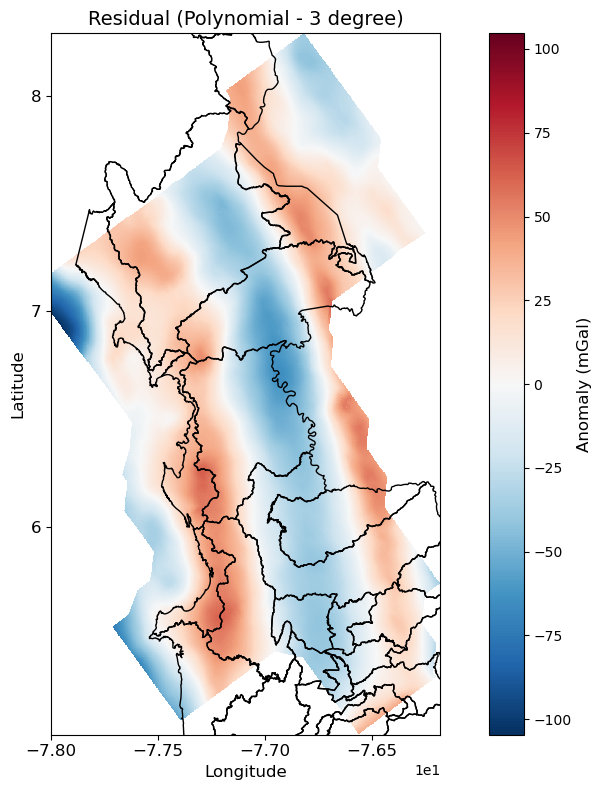

In [10]:
raster_plotting.plot_raster_data(data.x, data.y, residual, data_type='GA', sampling=10, title ='Residual (Polynomial - 3 degree)', cmap='RdBu_r')
depto.plot(ax=plt.gca(), edgecolor='black', facecolor='none')
plt.xlim(data.x.min(), data.x.max())
plt.ylim(data.y.min(), data.y.max())
plt.show()

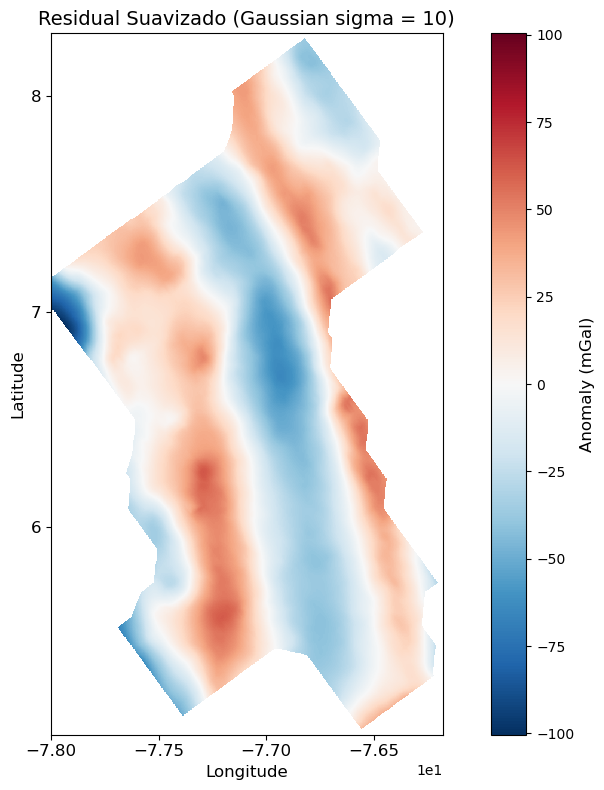

In [12]:
from scipy.ndimage import gaussian_filter

residual_grid = vd.make_xarray_grid(
    (data.x.values, data.y.values),
    residual,
    data_names="BOU_residual",
)

sigma = 10
residual_smoothed = gaussian_filter(residual_grid.BOU_residual.values, sigma=sigma)

residual_grid["BOU_residual"].values = residual_smoothed

raster_plotting.plot_raster_data(
    residual_grid.easting, residual_grid.northing, 
    residual_grid.BOU_residual,
    sampling=10,
    data_type='GA', title=f'Residual Suavizado (Gaussian sigma = {sigma})', 
    cmap='RdBu_r'
)

In [15]:
residual_grid.rio.write_crs("EPSG:4326", inplace=True)
residual_grid.rename({"easting": "x", "northing": "y"}).rio.to_raster(output_dir + rf'/raster/atrato_basin/BOU_residual_smoothed_gaussian_sigma_{sigma}.tif')

In [ ]:
del data_grid, data, regional, residual, raw_bou, trend_full, trend_model, lat, lon, coords_valid, bou_valid, valid_mask

## Total Horizontal Gradient

In [13]:
# sampling = 20
# residual_grid = residual_grid.isel(northing=slice(None, None, sampling), easting=slice(None, None, sampling))

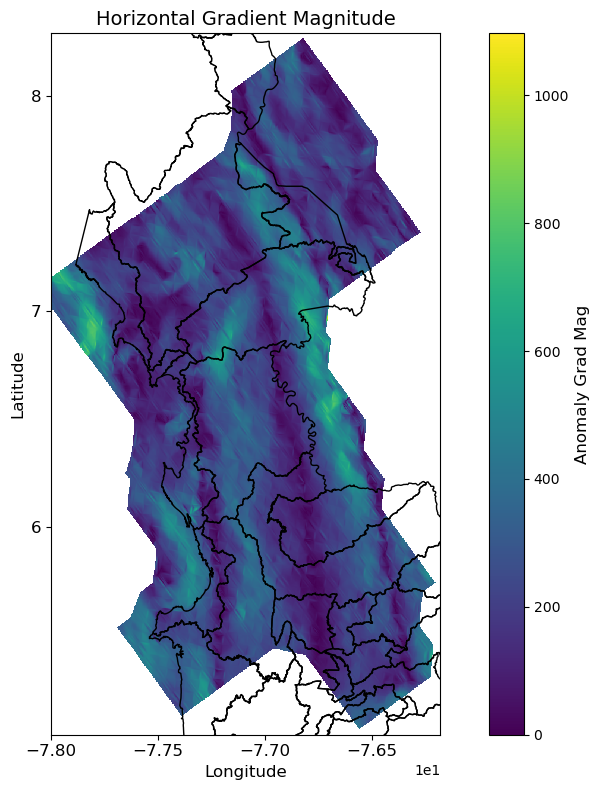

In [18]:
dy = np.diff(residual_grid.northing.values).mean()
dx = np.diff(residual_grid.easting.values).mean()

gy, gx = np.gradient(residual_grid.BOU_residual, dy, dx)
grad_mag_np = np.sqrt(gx**2 + gy**2)

raster_plotting.plot_raster_data(
    residual_grid.easting.values, 
    residual_grid.northing.values, 
    grad_mag_np, cmap='viridis', 
    vmin=0, 
    sampling = 10,
    title='Horizontal Gradient Magnitude', 
    data_title='Anomaly Grad Mag'
    )
depto.plot(ax=plt.gca(), edgecolor='black', facecolor='none')
plt.xlim(residual_grid.easting.min(), residual_grid.easting.max())
plt.ylim(residual_grid.northing.min(), residual_grid.northing.max())
plt.show()

In [19]:
grad_mag_np_grid = vd.make_xarray_grid(
    (residual_grid.easting, residual_grid.northing),
    grad_mag_np,
    data_names="grad_mag_np",
)
grad_mag_np_grid.rio.write_crs("EPSG:4326", inplace=True)
grad_mag_np_grid.rename({"easting": "x", "northing": "y"}).rio.to_raster(output_dir + r'/raster/atrato_basin/BOU_grad_mag_np.tif')

In [ ]:
filename = output_dir + r'/raster/atrato_basin/BOU_grad_mag_np.tif'
BOU_grad_mag_np = rioxarray.open_rasterio(filename)
BOU_grad_mag_np

<xarray.DataArray (band: 1, y: 11732, x: 6554)> Size: 615MB
[76891528 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 94kB 8.292 8.292 8.292 8.291 ... 5.034 5.034 5.034
  * x            (x) float64 52kB -78.0 -78.0 -78.0 ... -76.18 -76.18 -76.18
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      grad_mag_np

## Total Gradient Amplitud (Analytic Signal)

In [21]:
residual_grid = residual_grid.sortby(['easting', 'northing'])

c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


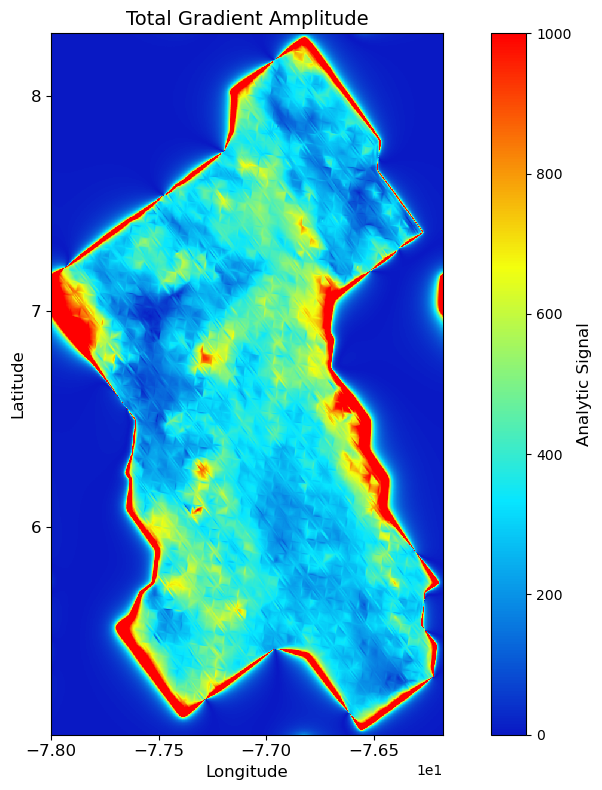

In [ ]:
tga = hm.total_gradient_amplitude(residual_grid.BOU_residual.fillna(0))
raster_plotting.plot_raster_data(
    tga.easting, 
    tga.northing, 
    tga.values, 
    data_type='GA', 
    sampling=10, 
    vmax=1000, 
    vmin=0,
    title='Total Gradient Amplitude',
    data_title='Analytic Signal'
)

## Geology

In [24]:
geojson_path = os.path.join(output_dir, "vector", "pacifico_structures.geojson")
gdf = gpd.read_file(geojson_path)

['Lineamientos' 'Fallas' 'Pliegues']


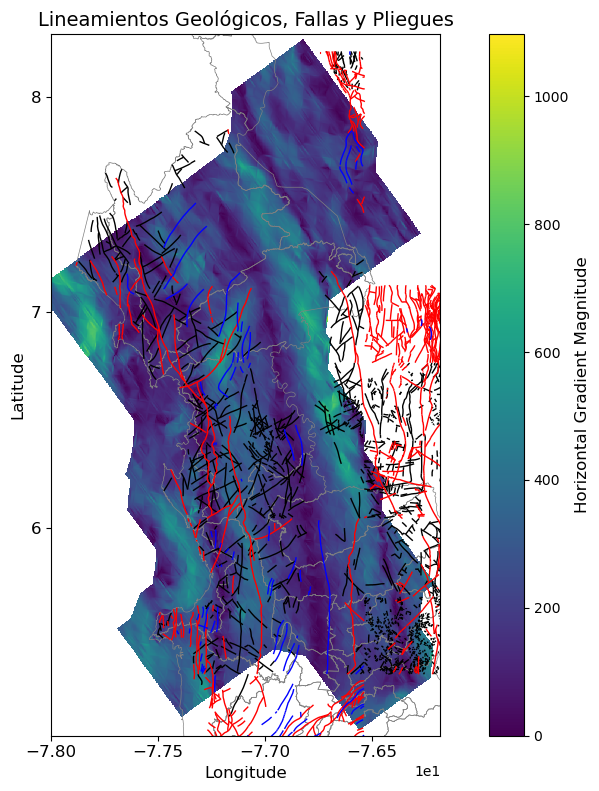

In [ ]:
print(gdf["Name"].unique())

lineamientos = gdf[gdf["Name"].str.contains("Lineamientos", case=False, na=False)]
fallas       = gdf[gdf["Name"].str.contains("Fallas", case=False, na=False)]
pliegues     = gdf[gdf["Name"].str.contains("Pliegues", case=False, na=False)]

raster_plotting.plot_raster_data(
    grad_mag_np_grid.easting.values,
    grad_mag_np_grid.northing.values,
    grad_mag_np_grid.grad_mag_np,
    cmap='viridis',
    vmin=0,
    sampling=10,
    data_title='Horizontal Gradient Magnitude'
)

ax = plt.gca()
lineamientos.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
fallas.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1)
pliegues.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
depto.plot(ax=ax, edgecolor='gray', facecolor='none', linewidth=0.5)

plt.xlim(data.x.min(), data.x.max())
plt.ylim(data.y.min(), data.y.max())
plt.title("Lineamientos Geológicos, Fallas y Pliegues", fontsize=14)
plt.show()

## Upward Continuation

In [35]:
mask_path = os.path.join(output_dir, "masks", "mask_of_gravity_data.shp")
gdf_mask = gpd.read_file(mask_path)
gdf_mask = gdf_mask.to_crs("EPSG:4326")  # ajusta si tu DEM usa otro CRS

data_bog = data.rio.clip(
    gdf_mask.geometry,
    gdf_mask.crs,
    drop=True,
    invert=False
)

In [36]:
data_bog = data.rio.reproject("EPSG:3116", inplace=True)

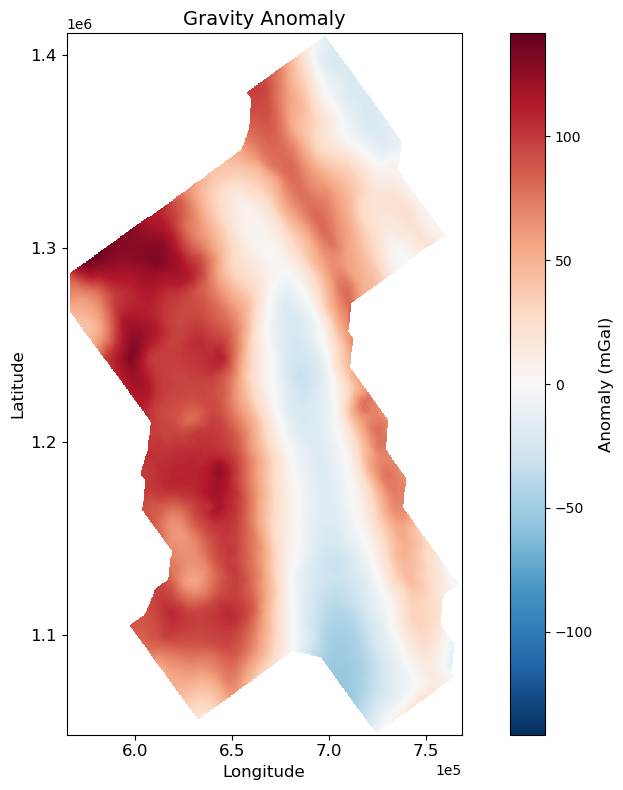

In [37]:
raster_plotting.plot_raster_data(data_bog.x, data_bog.y, data_bog[0], data_type='GA', sampling=10, cmap='RdBu_r')

### Suavizado

In [38]:
# 1. Reducir muestras (submuestreo)
sampling_factor = 200
data_bog_subsampled = data_bog.isel(
    x=slice(None, None, sampling_factor),
    y=slice(None, None, sampling_factor)
)

# 2. Extraer puntos válidos del submuestreo
mask_valid = ~np.isnan(data_bog_subsampled[0].values)
y_grid, x_grid = np.meshgrid(
    data_bog_subsampled.y.values, 
    data_bog_subsampled.x.values, 
    indexing='ij'
)

coords_valid = (y_grid[mask_valid], x_grid[mask_valid])
values_valid = data_bog_subsampled[0].values[mask_valid]

print(f"Número de puntos en la grilla submuestreada: {data_bog_subsampled[0].size}")
print(f"Número de puntos válidos para ajuste de spline: {len(values_valid)}")

# 3. Crear spline con los datos submuestreados
spline = vd.Spline(damping=1e-3)
spline.fit(coords_valid, values_valid)

# 4. Interpolar de vuelta a la grilla original completa
y_full, x_full = np.meshgrid(data_bog.y.values, data_bog.x.values, indexing='ij')
mask_original = ~np.isnan(data_bog[0].values)

# Predecir solo en puntos que originalmente tenían datos
coords_to_predict = (y_full[mask_original], x_full[mask_original])
values_interpolated = spline.predict(coords_to_predict)

# 5. Crear array con resultados
result = np.full_like(data_bog[0].values, np.nan)
result[mask_original] = values_interpolated

# 6. Crear nuevo DataArray con datos suavizados
data_bog_smoothed = data_bog.copy()
data_bog_smoothed[0].values = result

data_bog_smoothed

Número de puntos en la grilla submuestreada: 2006
Número de puntos válidos para ajuste de spline: 1102


<xarray.DataArray (band: 1, y: 11774, x: 6622)> Size: 624MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(1, 11774, 6622))
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 94kB 1.411e+06 1.411e+06 ... 1.049e+06 1.049e+06
  * x            (x) float64 53kB 5.647e+05 5.647e+05 ... 7.683e+05 7.684e+05
    spatial_ref  int64 8B 0
Attributes:
    long_name:      BOU
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

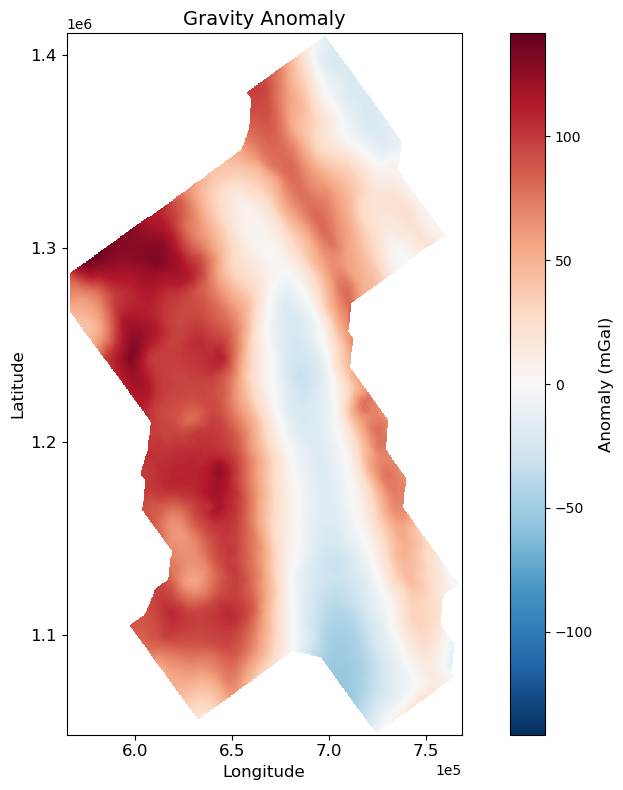

In [39]:
raster_plotting.plot_raster_data(data_bog_smoothed.x, data_bog_smoothed.y, data_bog_smoothed[0], data_type='GA', sampling=10, cmap='RdBu_r')

In [40]:
data_bog = data_bog_smoothed.sortby(['x', 'y'])

In [43]:
mask_nan = np.isnan(data_bog[0].values)

mean_value = np.nanmean(data_bog[0].values)
data_temp = data_bog[0].fillna(mean_value)

upwar_cont = hm.upward_continuation(data_temp, height_displacement=8000)

upwar_cont.values[mask_nan] = np.nan
upwar_cont

c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray (y: 11774, x: 6622)> Size: 624MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(11774, 6622))
Coordinates:
  * y        (y) float64 94kB 1.049e+06 1.049e+06 ... 1.411e+06 1.411e+06
  * x        (x) float64 53kB 5.647e+05 5.647e+05 ... 7.683e+05 7.684e+05

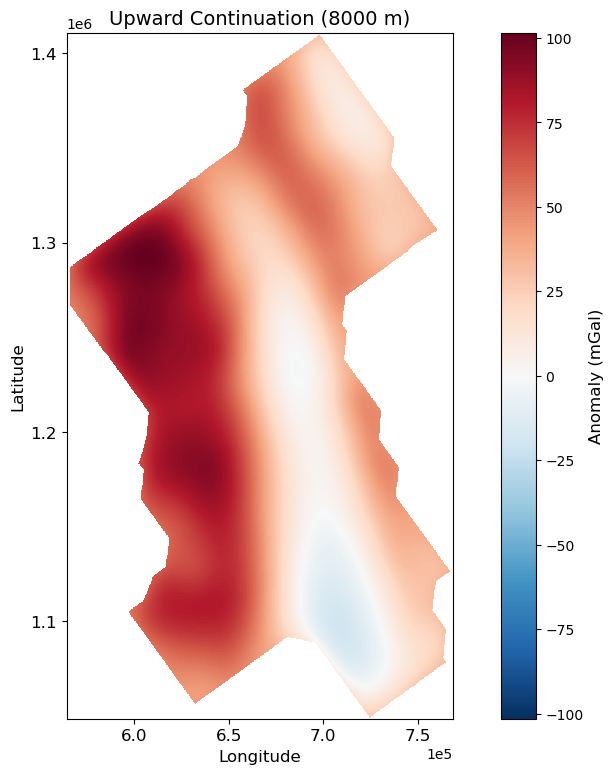

In [44]:
raster_plotting.plot_raster_data(upwar_cont.x, upwar_cont.y, upwar_cont.values, data_type='GA', sampling=10, title ='Upward Continuation (8000 m)', cmap='RdBu_r')

In [45]:
residual_grid_bog = vd.make_xarray_grid(
    (upwar_cont.x.values, upwar_cont.y.values),
    data_bog[0].values - upwar_cont.values,
    data_names="residual_upward",
)

sigma = 20 
residual_smoothed = gaussian_filter(residual_grid_bog.residual_upward.values, sigma=sigma)
residual_grid_bog["residual_upward"].values = residual_smoothed

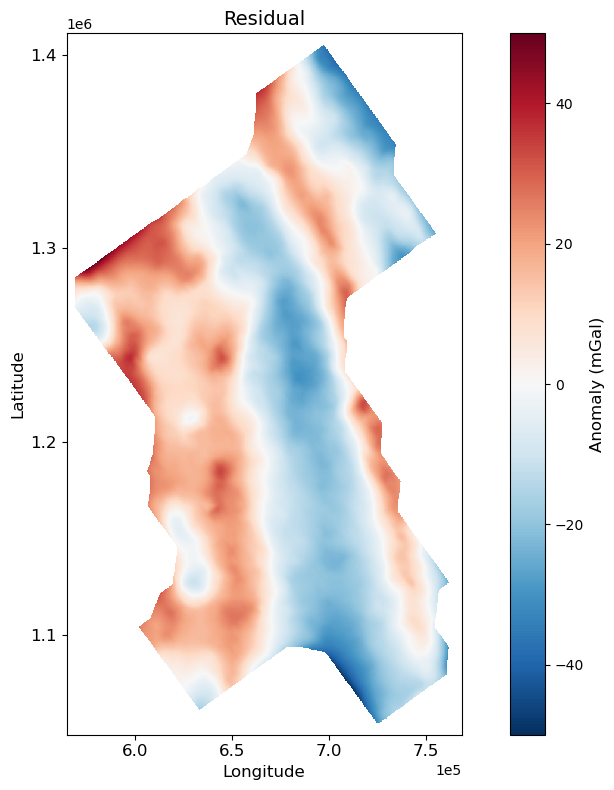

In [46]:
raster_plotting.plot_raster_data(residual_grid_bog.easting, residual_grid_bog.northing, residual_grid_bog.residual_upward.values, data_type='GA', title ='Residual', cmap='RdBu_r', sampling=10, vmax=50, vmin=-50)

## Upward derivative

In [48]:
deriv_upward = hm.derivative_upward(residual_grid_bog.residual_upward.fillna(0))

c:\Users\jasolanoz\AppData\Local\anaconda3\envs\lineament-detection\Lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


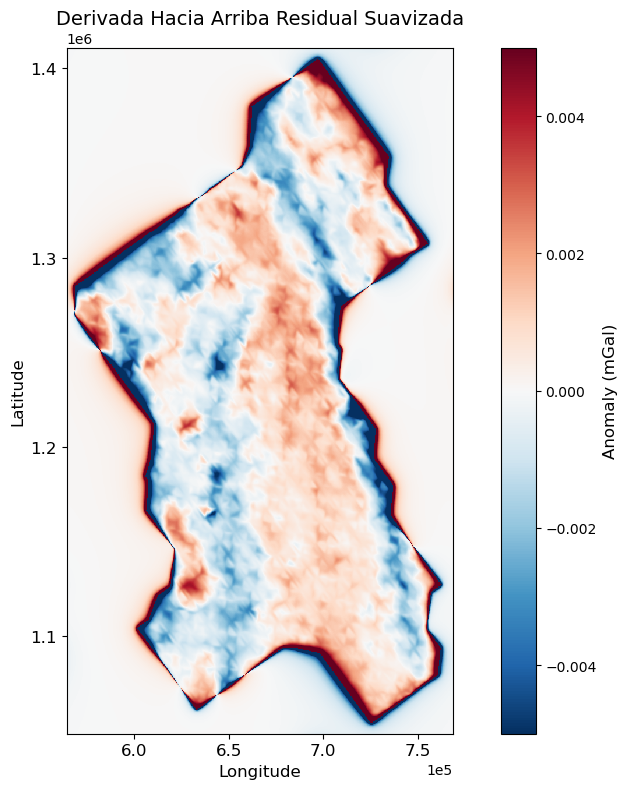

In [50]:
raster_plotting.plot_raster_data(deriv_upward.easting, deriv_upward.northing, deriv_upward.values, data_type='GA', title ='Derivada Hacia Arriba Residual Suavizada', cmap='RdBu_r', sampling=10, vmax=0.005, vmin=-0.005)